In [105]:
import pandas as pd
import numpy as np

In [106]:
data = pd.read_csv('../data/data_ex_2.csv')

In [107]:
data = data[['neighbourhood_group',
'room_type',
'latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']]

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   room_type                       48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   price                           48895 non-null  int64  
 5   minimum_nights                  48895 non-null  int64  
 6   number_of_reviews               48895 non-null  int64  
 7   reviews_per_month               38843 non-null  float64
 8   calculated_host_listings_count  48895 non-null  int64  
 9   availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 3.7+ MB


In [109]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [110]:
data.fillna(0, inplace=True)

# Question 1

In [111]:
data['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

most frequent observation: Manhattan

# Split the data

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [114]:
y_train = df_train.pop('price')
y_val = df_val.pop('price')
y_test = df_test.pop('price')

# Question 2

In [115]:
df_train.corr()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.080301,0.027441,-0.006246,-0.007159,0.019375,-0.005891
longitude,0.080301,1.000000,-0.060660,0.055084,0.134642,-0.117041,0.083666
minimum_nights,0.027441,-0.060660,1.000000,-0.076020,-0.120703,0.118647,0.138901
number_of_reviews,-0.006246,0.055084,-0.076020,1.000000,0.590374,-0.073167,0.174477
reviews_per_month,-0.007159,0.134642,-0.120703,0.590374,1.000000,-0.048767,0.165376
calculated_host_listings_count,0.019375,-0.117041,0.118647,-0.073167,-0.048767,1.000000,0.225913
availability_365,-0.005891,0.083666,0.138901,0.174477,0.165376,0.225913,1.000000


In [116]:
(df_train.corr() - np.eye(len(df_train.select_dtypes(include=np.number).columns))).abs().max()

latitude                          0.080301
longitude                         0.134642
minimum_nights                    0.138901
number_of_reviews                 0.590374
reviews_per_month                 0.590374
calculated_host_listings_count    0.225913
availability_365                  0.225913
dtype: float64

the numeric features with the biggest correlation are number_of_reviews and reviews_per_month 

# Make price binary

In [117]:
above_average_train = (y_train >= 152).astype(int)
above_average_val = (y_val >= 152).astype(int)

# Question 3

In [118]:
from sklearn.metrics import mutual_info_score

In [119]:
categorical = ['neighbourhood_group', 'room_type']
mi = df_train[categorical].apply(lambda series: mutual_info_score(series, above_average_train), axis=0).round(2)
mi.sort_values(ascending=False)

room_type              0.14
neighbourhood_group    0.05
dtype: float64

the room_type variable has the bigger score

# Question 4

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

In [121]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [122]:
df_train.iloc[0]

neighbourhood_group                      Brooklyn
room_type                         Entire home/apt
latitude                                  40.7276
longitude                               -73.94495
minimum_nights                                  3
number_of_reviews                              29
reviews_per_month                             0.7
calculated_host_listings_count                 13
availability_365                               50
Name: 13575, dtype: object

In [123]:
X_train[0]

array([ 50.     ,  13.     ,  40.7276 , -73.94495,   3.     ,   0.     ,
         1.     ,   0.     ,   0.     ,   0.     ,  29.     ,   0.7    ,
         1.     ,   0.     ,   0.     ])

In [124]:
model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42, max_iter=1500)

In [125]:
model.fit(X_train, above_average_train)

LogisticRegression(max_iter=1500, random_state=42)

In [126]:
y_pred = model.predict(X_val)

In [127]:
final_score = round((y_pred == above_average_val).mean(), 4)
final_score

0.7907

# Question 5

In [128]:
scores = {}
for feature in df_train.columns:
    features = [f for f in df_train.columns if f != feature]
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42, max_iter=1500)
    model.fit(X_train, above_average_train)
    y_pred = model.predict(X_val)
    
    print('excluded feature: ', feature)
    print('val score:', round((y_pred == above_average_val).mean(), 2))
    scores[feature] = round((y_pred == above_average_val).mean(), 4)

excluded feature:  neighbourhood_group
val score: 0.75
excluded feature:  room_type
val score: 0.73
excluded feature:  latitude
val score: 0.79
excluded feature:  longitude
val score: 0.79
excluded feature:  minimum_nights
val score: 0.79
excluded feature:  number_of_reviews
val score: 0.79
excluded feature:  reviews_per_month
val score: 0.79
excluded feature:  calculated_host_listings_count
val score: 0.79
excluded feature:  availability_365
val score: 0.78


In [129]:
features_to_test = ['neighbourhood_group', 'room_type', 'number_of_reviews', 'reviews_per_month'] 

for f in features_to_test:
    print(f, round(scores[f]-final_score, 4))

neighbourhood_group -0.0397
room_type -0.062
number_of_reviews 0.0005
reviews_per_month 0.0001


reviews_per_month has the smallest difference

# Question 6

In [130]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

<AxesSubplot:>

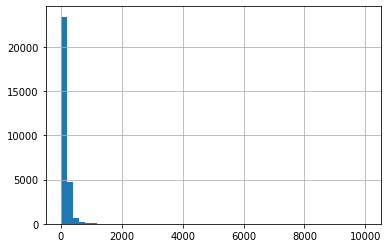

In [131]:
y_train.hist(bins=50)

In [132]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

<AxesSubplot:>

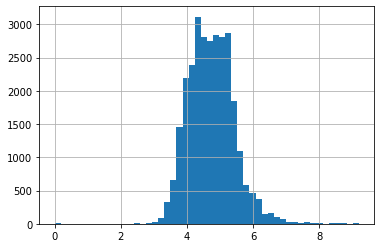

In [133]:
y_train_log.hist(bins=50)

In [134]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [135]:
alphas = [0, 0.01, 0.1, 1, 10]

In [136]:
for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_val)
    print(round(np.sqrt(mean_squared_error(np.expm1(y_pred_log), y_val)), 3), a)

213.418 0
213.47 0.01
213.473 0.1
213.496 1
213.686 10
